In [1]:
!pip install category_encoders

#Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

#dispplay options
pd.set_option("max_columns",500)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper Functions

In [3]:
def change_month_to_month_difference(df):
    if 'customer_id' not in df.columns:
        le = LabelEncoder()
        df['customer_id'] = le.fit_transform(df['customer_id_mskd'])

    if 'timestamp' not in df.columns:
        df['timestamp'] = pd.to_datetime(df['month'])
    
    output = {}
    for cust_id in df['customer_id'].unique():
        diff = df[df['customer_id'] == cust_id]['timestamp'].max() - df[df['customer_id'] == cust_id]['timestamp'].min()
        diff_int = int(diff/np.timedelta64(1,'M'))
        
        output[cust_id] = diff_int
    output = pd.DataFrame.from_dict(output, orient = 'index')
    output.columns = ['month_difference']
    #df = pd.merge(df, output, how = 'inner', left_on = 'customer_id', right_on = output.index)
    
    return output

In [4]:
def one_hot_encoder(df, column_name, drop_first = True):
    data = pd.get_dummies(df ,prefix=[column_name], columns = [column_name], drop_first = drop_first)
    return data

In [5]:
def data_prep(cust_df,tran_df,run_custDf = True, run_tranDf = True):
  
  if run_custDf:
    #preprocess customer data columns
    custDf = cust_df.copy()
    #make encode customer_id
    le_cust = LabelEncoder() #<--- to be used in tranDf for customer_id_maskd
    custDf['customer_Id'] = le_cust.fit_transform(custDf['customer_id_mskd'])

    #drop customer_id_mskd
    custDf.drop('customer_id_mskd',axis=1,inplace= True)

    #replace NULL in count features (PCD and SRV) with 0
    featCount = [col for col in custDf.columns if ('PCD' in col) or ('SRV' in col)]
    custDf[featCount] = custDf[featCount].fillna(0)

    #drop export_ts
    custDf.drop('export_ts',axis = 1, inplace = True)

    #drop industry_code_aml if all none
    if custDf.industry_code_aml.isnull().sum() == len(custDf):
      custDf.drop('industry_code_aml', axis = 1, inplace = True)

    # ------add other preprocessing for custDf here-----------

  if run_tranDf:

    #----------------------preprocess tranDf------------------
    tranDf = tran_df.copy()
    #encode customer ids using same encoder as in custDf
    tranDf['customer_id'] = le_cust.transform(tranDf['customer_id_mskd'])

    #drop customer_id_mskd
    tranDf.drop('customer_id_mskd',inplace = True, axis = 1)

    #process the month column
    months_diff =change_month_to_month_difference(tranDf) #returns customer_id as index and month's diff as columns
    

    #replace NULL with 0 in 'in_amt', 'in_cnt', 'out_amt', 'out_cnt'
    featTran = ['in_amt', 'in_cnt', 'out_amt', 'out_cnt']
    tranDf[featTran] = tranDf[featTran].fillna(0)

    #groupby custumer_id, sum for 'in_amt', 'in_cnt', 'out_amt', 'out_cnt'

    gpby = tranDf.groupby(by = 'customer_id')
    tranSum = gpby[featTran].sum()

    tranSum = pd.merge(tranSum, months_diff, left_on = tranSum.index, right_on = months_diff.index, how = 'inner')
    tranSum.rename(columns={'key_0':'customer_Id'},inplace = True)

    #to return tranSum
    return [custDf,tranSum]

In [6]:
def random_forest_classifier(x_train_encoded,
                             x_test_encoded,
                             y_train,
                             y_test,
                             quickTrain = False):

  if quickTrain:
    params = {
      'max_depth': 10,
      'n_estimators': 100,
      'max_leaf_nodes':10
      }
    model = RandomForestClassifier(**params)
    model.fit(x_train_encoded,y_train)
    
  else:
    params = {
      'max_depth': [5,10,15,20],
      'n_estimators': [50,100,150],
      'max_leaf_nodes':[10,12,14]
    }

    model = GridSearchCV(RandomForestClassifier(),param_grid=params, cv = 5)
    model.fit(x_train_encoded,y_train)
    best_score = model.best_score_
    print("Best Score: ", best_score)
    params = model.get_params()
  
  pred_test = model.predict(x_test_encoded)
  pred_train = model.predict(x_train_encoded)

  probs = model.predict_proba(x_test_encoded)


  print("Accuracy on test set: ", accuracy_score(y_test,pred_test))

  print("Accuracy on train set: ", accuracy_score(y_train,pred_train))
  #print("Feature Importance: ")
  #print(model.feature_importances_)

  return [model,params,pred_test, probs]

In [7]:
def GradientBoostClassifier(x_train_encoded,
                             x_test_encoded,
                             y_train,
                             y_test,
                             quickTrain = False):

  if quickTrain:
    params = {
      'max_depth': 10,
      'n_estimators': 100,
      'max_leaf_nodes':10,
      'min_weight_fraction_leaf': 0.5
      }
    model = GradientBoostClassifier(**params)
    model.fit(x_train_encoded,y_train)

  else:
    params = {
      'max_depth': [5,10,15,20],
      'n_estimators': [50,100,150],
      'max_leaf_nodes':[10,12,14],
      'min_weight_fraction_leaf': [0.01,0.1,0.05]
    }
    
    model = GridSearchCV(GradientBoostClassifier(),param_grid=params, cv = 5)
    model.fit(x_train_encoded,y_train)
    best_score = model.best_score_
    print("Best Score: ", best_score)
    params = model.get_params()
  
  pred_test = model.predict(x_test_encoded)
  pred_train = model.predict(x_train_encoded)

  probs = model.predict_proba(x_train_encoded)

  print("Accuracy on test set: ", accuracy_score(y_test,pred_test))

  print("Accuracy on train set: ", accuracy_score(y_train,pred_train))
  #print("Feature Importance: ")
  #print(model.feature_importances_)

  return [model,params,pred_test, probs]

In [8]:
def XGBClassifier(x_train_encoded,
                             x_test_encoded,
                             y_train,
                             y_test,
                             quickTrain = False):

  if quickTrain:
    params = {
      'max_depth': 10,  ## you can change it 
      'eta': 3, # learning rate
      'min_child_weight':1,
      'min_split_loss': 0.5
      }

    model = XGBClassifier(**params) #<---check it later
    model.fit(x_train_encoded,y_train)
    
  else:
    params = {
      'max_depth': [5,8,10],  ## you can change it 
      'eta':[0.01,0.1,0.3], # learning rate
      'min_child_weight': [1, 10, 100],
      'min_split_loss': [0.5,1,5],
      'sampling_method': ['gradient_based']
    }

    model = GridSearchCV(XGBClassifier(),param_grid=params, cv = 5)
    model.fit(x_train_encoded,y_train)
    best_score = model.best_score_
    print("Best Score: ", best_score)
    params = model.get_params()

  pred_test = model.predict(x_test_encoded)
  pred_train = model.predict(x_train_encoded)

  probs = model.predict_proba(x_train_encoded)

  print("Accuracy on test set: ", accuracy_score(y_test,pred_test))

  print("Accuracy on train set: ", accuracy_score(y_train,pred_train))
  #print("Feature Importance: ")
  #print(model.feature_importances_)

  return [model,params,pred_test, probs]

In [9]:
def train_models(cust_df, tran_df, Encoder,
                 featCat,
                 featNum,
                 merge = True, 
                 run_log_classifier = False,
                 run_rfclassifier = False,
                 run_xgclassifier = False,
                 run_gbclassifier = False,
                 quickTrain = False):
  
  custDf = cust_df.copy()
  tranDf = tran_df.copy()
  if merge:
    data = pd.merge(custDf,tranDf, on= 'customer_Id',how = 'inner' )
  else:
    data = custDf
  
  #shuffle data
  data = data.sample(frac = 1)

  data = data[featCat+featNum+['rating']]

  #split test and train set
  x_train, x_test, y_train, y_test = train_test_split(data.drop('rating',axis = 1),data['rating'],
                                                      test_size = 0.15, random_state = 13)

  #print(y_test.value_counts())
  #print(featCat)
  
  x_train_encoded = catEncoder.fit_transform(x_train, y_train)
  x_test_encoded = catEncoder.transform(x_test)
  #print(x_train_encoded)

  #standardization
  scaler = StandardScaler()
  x_train_std = scaler.fit_transform(x_train_encoded)
  x_test_std = scaler.transform(x_test_encoded)

  if run_rfclassifier:
    [model_rfc, best_score_rfc,pred_test, probs] = random_forest_classifier(x_train_encoded,
                                                           x_test_encoded, 
                                                           y_train,
                                                           y_test,
                                                           quickTrain= quickTrain)

  if run_xgclassifier:
    [model_rfc, best_score_rfc,pred_test, probs] = XGBClassifier(x_train_encoded,
                                                          x_test_encoded, 
                                                          y_train,
                                                          y_test,
                                                          quickTrain= quickTrain)

  if run_gbclassifier:
    [model_rfc, best_score_rfc,pred_test] = GradientBoostClassifier(x_train_encoded,
                                                           x_test_encoded, 
                                                           y_train,
                                                           y_test,
                                                           quickTrain = quickTrain)

  chosen_model = model_rfc
  predictions = pred_test
  proba = probs
  return [chosen_model,predictions,proba]

#start from here

In [10]:
custDf = pd.read_parquet('cust_train.parquet')
tranDf = pd.read_parquet("transaction_train.parquet")

In [11]:
custDf.head(5)

,customer_id_mskd,jurisdiction_code,client_type_aml,industry_code_aml,occupation_code_aml,country_of_domicile_aml,occupation_status_code_aml,customer_status_aml,export_ts,primary_ownership_flag,relationship_type,PCD_CDA,PCD_CMS,PCD_CRC,PCD_LLC,PCD_MOR,PCD_MUF,PCD_SAV,PCD_SDB,PCD_TED,SRV_FLG,SRV_FSL,SRV_ILC,SRV_LOC,SRV_NLG,SRV_NSL,SRV_TRF,PRD_INFO_AVAIL,rating
0,df39588796bc20fb01d282213200c944ad38caa06a91a7...,CA03,Individual,None,108,CA,None,Active,2020-05-13,N,Joint,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.0
1,d56f5632aa40d2661dcc5419def6ede2ed4cca24bd76cd...,CA03,Individual,None,342,CA,None,Active,2020-05-13,Y,Borrower,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.0
2,a86efc98b6e70bbb37c12024304f3d7c9eac9e4ecd9559...,CA03,Individual,None,E902,CA,E902,Active,2020-05-13,Y,Borrower,NaN,NaN,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.0
3,24f154d9bb05a18ba723830b6c41d6eb71a67f14ca7325...,CA03,Individual,None,94,CA,None,Active,2020-05-13,Y,Primary Joint,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.0
4,bdb58c996ed0b5c9f81461caa8efe914f712e22ffaa6ac...,CA03,Individual,None,256,CA,None,Active,2020-05-13,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.0


In [12]:
[cust_df, tran_df] = data_prep(custDf,tranDf,run_custDf = True, run_tranDf = True)

In [13]:
cust_df.head(10)

,jurisdiction_code,client_type_aml,occupation_code_aml,country_of_domicile_aml,occupation_status_code_aml,customer_status_aml,primary_ownership_flag,relationship_type,PCD_CDA,PCD_CMS,PCD_CRC,PCD_LLC,PCD_MOR,PCD_MUF,PCD_SAV,PCD_SDB,PCD_TED,SRV_FLG,SRV_FSL,SRV_ILC,SRV_LOC,SRV_NLG,SRV_NSL,SRV_TRF,PRD_INFO_AVAIL,rating,customer_Id
0,CA03,Individual,108,CA,None,Active,N,Joint,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.0,3946
1,CA03,Individual,342,CA,None,Active,Y,Borrower,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.0,3752
2,CA03,Individual,E902,CA,E902,Active,Y,Borrower,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.0,2978
3,CA03,Individual,94,CA,None,Active,Y,Primary Joint,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.0,657
4,CA03,Individual,256,CA,None,Active,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,3.0,3339
5,CA03,Individual,None,CA,None,Active,N,Co-Borrower,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.0,3592
6,CA03,Individual,E902,CA,E902,Active,N,Joint,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.0,967
7,CA03,Individual,256,CA,None,Active,N,Co-signor,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.0,423
8,CA03,Individual,E904,CA,E904,Active,Y,Sole,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.0,2224
9,CA03,Individual,256,CA,None,Active,Y,Sole,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.0,3128


In [14]:
tran_df.head(10)

,customer_Id,in_amt,in_cnt,out_amt,out_cnt,month_difference
0,1,0.00,0.0,192.01,19.0,2
1,2,546.28,12.0,19267.28,298.0,12
2,5,11702.48,23.0,11619.68,360.0,12
3,6,8443.46,17.0,41571.22,875.0,12
4,8,286006.65,169.0,442407.21,119.0,12
5,9,49085.44,149.0,74693.80,769.0,12
6,10,222567.42,22.0,211251.24,187.0,12
7,11,50290.51,35.0,133714.32,129.0,12
8,13,473807.00,50.0,473700.45,277.0,11
9,15,0.00,0.0,1000.00,1.0,0


In [15]:
featCat =  ['jurisdiction_code', 
           'client_type_aml',
           # 'industry_code_aml',
           'occupation_code_aml',
           #'country_of_domicile_aml',
           'occupation_status_code_aml',
           'customer_status_aml',
          # 'export_ts',
           'primary_ownership_flag',
           'relationship_type',
           'PCD_CDA',
           'PCD_CMS',
           'PCD_CRC',
           'PCD_LLC', 
           'PCD_MOR',
           'PCD_MUF',
           'PCD_SAV',
           'PCD_SDB',
           'PCD_TED',
           'SRV_FLG',
           'SRV_FSL',
           'SRV_ILC',
           'SRV_LOC',
           'SRV_NLG',
           'SRV_NSL', 
           'SRV_TRF', 
           'PRD_INFO_AVAIL',
            'month_difference'
          ]

In [16]:
featNum = ['in_amt',	'in_cnt',	'out_amt',	'out_cnt']

In [17]:
tran_df.head(3)

,customer_Id,in_amt,in_cnt,out_amt,out_cnt,month_difference
0,1,0.00,0.0,192.01,19.0,2
1,2,546.28,12.0,19267.28,298.0,12
2,5,11702.48,23.0,11619.68,360.0,12


In [18]:
catEncoder = MEstimateEncoder(cols = featCat)#check parameters for encoders
[model,prediction, probs] =train_models(cust_df, tran_df, catEncoder,
                 featCat,
                 featNum,
                 merge = True, 
                 run_log_classifier = False,
                 run_rfclassifier = True,
                 run_gbclassifier = False,
                 run_xgclassifier = False,
                 quickTrain = False)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Best Score:  0.5170712058212058
Accuracy on test set:  0.45647058823529413
Accuracy on train set:  0.5362198168193172


In [19]:
np.unique(prediction,return_counts=True)

(array([1., 2., 3.]), array([ 33, 311,  81]))

In [41]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
y = label_binarize(prediction, classes = [1,2,3])

def precision_recall(Y_test, y_score):
  precision = dict()
  recall = dict()
  average_precision = dict()

  for i in range(3):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                          y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
      y_score.ravel())
  average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                      average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))

  plt.figure()
  plt.step(recall['micro'], precision['micro'], where='post')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(
      'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
      .format(average_precision["micro"]))
  plt.show()

Average precision score, micro-averaged over all classes: 0.98


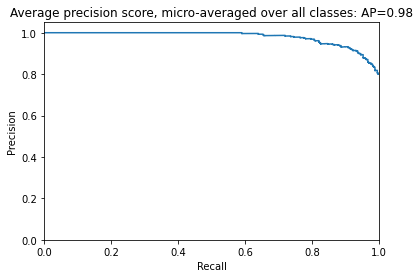

In [42]:
precision_recall(y,probs)

In [92]:
from sklearn.metrics import roc_curve, auc, f1_score, plot_confusion_matrix


def roc(y_test,y_score): 
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # print(y_test.shape, y_score.shape)
  # fpr, tpr = roc_curve(y_test[:, 2], y_score[:, 2])
  # roc_auc = auc(fpr, tpr)
  
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  plt.figure()
  lw = 2
  for i in range(3):
    plt.plot(fpr[i], tpr[i],
          lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i,roc_auc[i]))
  
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

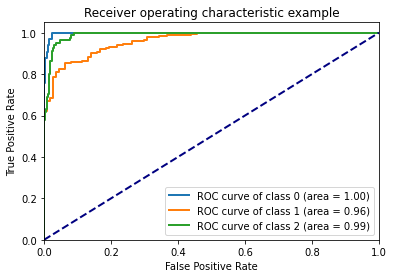

In [91]:
roc(y, probs)

In [94]:

def f1score(y_pred,y_true):
  f1_score(y_pred,y_true)


def ConfusionMatrix(y_pred,y_true):
  cm = confusion_matrix(y_pred,y_true)
  sns.heatmap(cm, annot=True)
  